In [1]:
import numpy as np
import pandas as pd
from classes.ml_file_loader import load_ml_model_from_file
import classes.lime_extensions.lime_extensions as le
from lime.lime_text import LimeTextExplainer
import re
import sklearn
import time
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
df = pd.read_csv('./datasets/data.csv')
model_tfidf = load_ml_model_from_file('models/LemmaTfIdfNNClassifierTraining.pkl')
model_tfidf.force_cpu = False
model_lstm = load_ml_model_from_file('models/LstmClassifierTraining.pkl')
test_sentence = df['text'].iloc[321]
model_tfidf.predict(test_sentence)

Load Model Duration 00:00:02.349 GMT


array([[0.953453  , 0.04654708]], dtype=float32)

# Experiment 1


In [3]:
def experiment1(data, model, sample_size=[2, 30, 100, 300, 1000, 10000], step_size=[2, 10, 20, 50, 100]):
    output={
        'data' : data,
        'ground_truth' : None,
        'time':0,
        'sample_size' : [],
        'random':{
            'coefficients' : [],
            'MSE' : [],
            'MAE' : [],
            'score':[]
        },
        'advanced':{
            'coefficients' : [],
            'MSE' : [],
            'MAE': [],
            'score':[]
        }
    }
    
    #Init Explainer
    #------------------------------------
    ground_truth = le.ES_LimeTextExplainer(class_names=['Real', 'Fake'])
    explainer_random = le.CacheLimeTextExplainer(class_names=['Real', 'Fake'])
    explainer_random.advancedSampler = False
    explainer_deter = le.CacheLimeTextExplainer(class_names=['Real', 'Fake'])
    
    #feature size for all words
    feature_size = 2**len(set(re.split('\W+',data)))
    
    #initialize directly for max samples
    explainer_random.explain_instance(data, model.predict, num_features=feature_size)
    explainer_deter.explain_instance(data, model.predict, num_features=feature_size)
    
    #Create Ground Truth
    #------------------------------------
    exp = ground_truth.explain_instance(data, model.predict, num_features=feature_size, num_samples=sample_size[-1])
    ground_truth = sorted(exp.as_list())
    output['ground_truth'] = ground_truth
    
    
    #Create Step Size
    #------------------------------------
    iterat_array = []
    for i in range(len(sample_size)-1):
        iterat_array.extend(np.arange(sample_size[i], sample_size[i+1], step_size[i]))
    iterat_array.extend([sample_size[-1]])
    

    
    #Perform experiments
    #-------------------------------------
    start = time.time()
    #For more efficient batch processing, create directly with max samples
    explainer_random.explain_instance(data, model.predict, num_features=feature_size, num_samples=iterat_array[-1])
    explainer_deter.explain_instance(data, model.predict, num_features=feature_size, num_samples=iterat_array[-1])
    for i in iterat_array:
        exp_random = explainer_random.explain_instance(data, model.predict, num_features=feature_size, num_samples=i)
        exp_deter = explainer_deter.explain_instance(data, model.predict, num_features=feature_size, num_samples=i)
            
        mse_random = sklearn.metrics.mean_squared_error([x[1] for x in ground_truth],
                                                            [x[1] for x in sorted(exp_random.as_list())])
            
        mse_deter = sklearn.metrics.mean_squared_error([x[1] for x in ground_truth],
                                                            [x[1] for x in sorted(exp_deter.as_list())])
            
        mae_random = sklearn.metrics.mean_absolute_error([x[1] for x in ground_truth],
                                                            [x[1] for x in sorted(exp_random.as_list())])
            
        mae_deter = sklearn.metrics.mean_absolute_error([x[1] for x in ground_truth],
                                                            [x[1] for x in sorted(exp_deter.as_list())])
        
        output['sample_size'].append(i)
        output['random']['coefficients'].append(sorted(exp_random.as_list()))
        output['random']['MSE'].append(mse_random)
        output['random']['MAE'].append(mae_random)
        output['random']['score'].append(exp_random.score)
        
        output['advanced']['coefficients'].append(sorted(exp_deter.as_list()))
        output['advanced']['MSE'].append(mse_deter)
        output['advanced']['MAE'].append(mae_deter)
        output['advanced']['score'].append(exp_deter.score)
    end = time.time()
    output['time'] = end-start
    return output

def experiment_one_to_df(experiment, experiment_id=None):
    random = pd.DataFrame()
    advanced = pd.DataFrame()
    

    random['sample_size'] = experiment['sample_size']
    advanced['sample_size'] = experiment['sample_size']
    random['data'] = experiment['data']
    advanced['data'] = experiment['data']
    random['time'] = experiment['time']
    advanced['time'] = experiment['time']
    random['id'] = experiment_id
    advanced['id'] = experiment_id
    random['ground_truth'] = [experiment['ground_truth'] for x in range(len(experiment['sample_size']))]
    advanced['ground_truth'] = [experiment['ground_truth'] for x in range(len(experiment['sample_size']))]
    
    random['score'] = experiment['random']['score']
    random['MAE'] = experiment['random']['MAE']
    random['MSE'] = experiment['random']['MSE']
    random['coefficients'] = experiment['random']['coefficients']
    random['Mode'] = 'Random'
    advanced['score'] = experiment['advanced']['score']
    advanced['MAE'] = experiment['advanced']['MAE']
    advanced['MSE'] = experiment['advanced']['MSE']
    advanced['Mode'] = 'Advanced'
    advanced['coefficients'] = experiment['advanced']['coefficients']
    
    df = pd.concat([random, advanced])
    return df
    
def experiment1_batch(data,model, model_name='', sample_size=[2, 30, 100, 300, 1000, 10000], step_size=[2, 10, 20, 50, 100]):
    df_index = pd.DataFrame(columns=['index','raw_text', 'ground_truth'])
    df = pd.DataFrame()
    
    for index, d in enumerate(data):
        start = time.time()
        result = experiment1(d, model, sample_size=sample_size, step_size=step_size)
        df_experiment=experiment_one_to_df(result, experiment_id=index)
        df = df.append(df_experiment)
        end = time.time()
        print(f'\nSample {index+1} of {len(data)} took {end-start} seconds')
    df['model_name'] = model_name
    return df

In [4]:
df['title_size'] = df['title'].astype(str).apply(lambda x: len(set(re.split('\W+', x))))
df_possible = df[(df['title_size'] < 16) & (df['title_size'] > 6)]
samples = df_possible.sample(100, random_state=1337)
samples['title']

21855    College Students Threatened by Cops for Handin...
5815     Bird Song, Sirens and Saxophones for a Stroll ...
16831    Coping With Extreme Weather If You’re Stranded...
2753     Chilling Clip From Adam Curtis Doc Should Make...
527      ‘Veep’ Season 5, Episode 7: Do a Little Dance ...
                               ...                        
4365     President Obama's Latest Scapegoat for the Oba...
13223    Watch: Steve Bannon Sworn in as President Trum...
18828    The Ghosts of Good Luck: Yeats and the Spectra...
2891     Woes for ITT, a For-Profit School, Bode Worse ...
7597     11 Great Reads That Have Nothing to Do With Po...
Name: title, Length: 100, dtype: object

In [5]:
start = time.time()
e = experiment1_batch(samples['title'], model_tfidf , model_name='LemmaTfIdfNNClassifier', sample_size=[2, 30, 100, 300, 1000, 5000, 10000], step_size=[2, 10, 20, 50, 100, 200])
end = time.time()
print(f'\nFinished in {end-start} seconds.')


e.to_csv("experiment1.csv")


Sample 1 of 100 took 12.588657855987549 seconds

Sample 2 of 100 took 39.107112407684326 seconds

Sample 3 of 100 took 8.540356874465942 seconds

Sample 4 of 100 took 23.32490634918213 seconds

Sample 5 of 100 took 30.5459201335907 seconds

Sample 6 of 100 took 16.690106868743896 seconds

Sample 7 of 100 took 25.95444655418396 seconds

Sample 8 of 100 took 16.61864995956421 seconds

Sample 9 of 100 took 16.83855414390564 seconds

Sample 10 of 100 took 24.853667736053467 seconds

Sample 11 of 100 took 9.829859733581543 seconds

Sample 12 of 100 took 9.423081874847412 seconds

Sample 13 of 100 took 17.09333038330078 seconds

Sample 14 of 100 took 12.435367584228516 seconds

Sample 15 of 100 took 37.72303485870361 seconds

Sample 16 of 100 took 8.760075330734253 seconds

Sample 17 of 100 took 9.511243343353271 seconds

Sample 18 of 100 took 7.59244179725647 seconds

Sample 19 of 100 took 9.346489906311035 seconds

Sample 20 of 100 took 34.24579095840454 seconds

Sample 21 of 100 took 13.

In [2]:
e = pd.read_csv('experiment1.csv')

In [3]:
e

,Unnamed: 0,sample_size,data,time,id,ground_truth,score,MAE,MSE,coefficients,Mode,model_name
0,0,2,College Students Threatened by Cops for Handin...,4.549844,0,"[('College', -0.09354349941323964), ('Constitu...",0.552978,0.026042,0.001957,"[('College', 0.0), ('Constitutions', 0.0), ('C...",Random,LemmaTfIdfNNClassifier
1,1,4,College Students Threatened by Cops for Handin...,4.549844,0,"[('College', -0.09354349941323964), ('Constitu...",0.552621,0.026197,0.001944,"[('College', 0.0), ('Constitutions', -0.000854...",Random,LemmaTfIdfNNClassifier
2,2,6,College Students Threatened by Cops for Handin...,4.549844,0,"[('College', -0.09354349941323964), ('Constitu...",0.686148,0.029160,0.001773,"[('College', -0.006108667113969686), ('Constit...",Random,LemmaTfIdfNNClassifier
3,3,8,College Students Threatened by Cops for Handin...,4.549844,0,"[('College', -0.09354349941323964), ('Constitu...",0.774815,0.025990,0.001261,"[('College', -0.03536413059443162), ('Constitu...",Random,LemmaTfIdfNNClassifier
4,4,10,College Students Threatened by Cops for Handin...,4.549844,0,"[('College', -0.09354349941323964), ('Constitu...",0.779760,0.024094,0.001103,"[('College', -0.03495624005203666), ('Constitu...",Random,LemmaTfIdfNNClassifier
...,...,...,...,...,...,...,...,...,...,...,...,...
22195,106,9200,11 Great Reads That Have Nothing to Do With Po...,10.145432,99,"[('11', 0.2059027437002322), ('Do', 3.52250530...",0.747614,0.003614,0.000029,"[('11', 0.22297008414539363), ('Do', -0.002935...",Advanced,LemmaTfIdfNNClassifier
22196,107,9400,11 Great Reads That Have Nothing to Do With Po...,10.145432,99,"[('11', 0.2059027437002322), ('Do', 3.52250530...",0.747798,0.003960,0.000031,"[('11', 0.22328536556606396), ('Do', -0.003446...",Advanced,LemmaTfIdfNNClassifier
22197,108,9600,11 Great Reads That Have Nothing to Do With Po...,10.145432,99,"[('11', 0.2059027437002322), ('Do', 3.52250530...",0.748490,0.004192,0.000033,"[('11', 0.2234521860537872), ('Do', -0.0038724...",Advanced,LemmaTfIdfNNClassifier
22198,109,9800,11 Great Reads That Have Nothing to Do With Po...,10.145432,99,"[('11', 0.2059027437002322), ('Do', 3.52250530...",0.747896,0.003937,0.000031,"[('11', 0.22313243848250958), ('Do', -0.003366...",Advanced,LemmaTfIdfNNClassifier


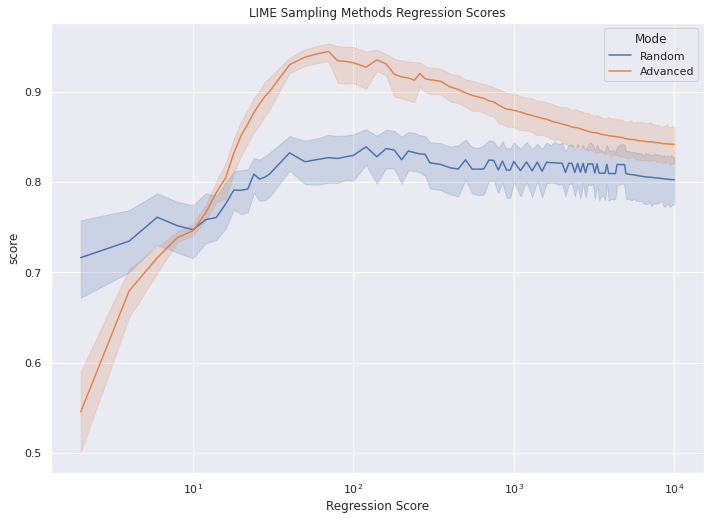

In [7]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.lineplot(data=e, x="sample_size", y='score', hue='Mode')
g.set(xscale="log") 
g.set(xlabel="Sample Size")
g.set(xlabel="Regression Score")
g.set(title="LIME Sampling Methods Regression Scores")
plt.savefig("./plots/scores.pdf")

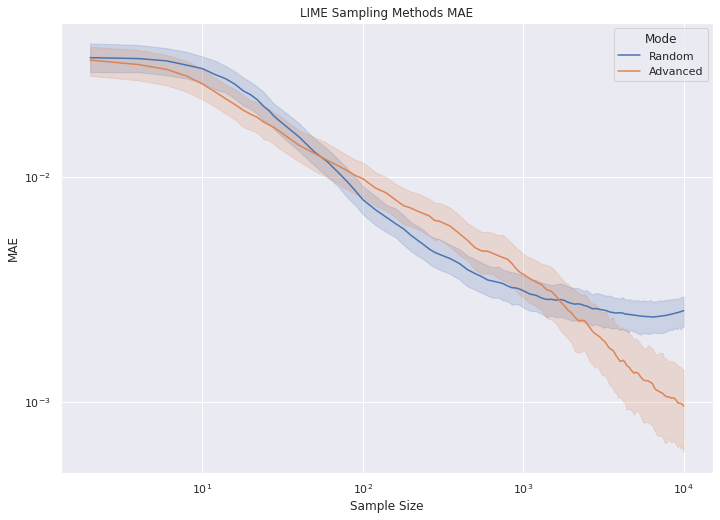

In [8]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.lineplot(data=e, x="sample_size", y='MAE', hue='Mode')
g.set(xscale="log") 
g.set(yscale="log")
g.set(xlabel="Sample Size")
g.set(ylabel="MAE")
g.set(title="LIME Sampling Methods MAE")
plt.savefig("./plots/mae.pdf")

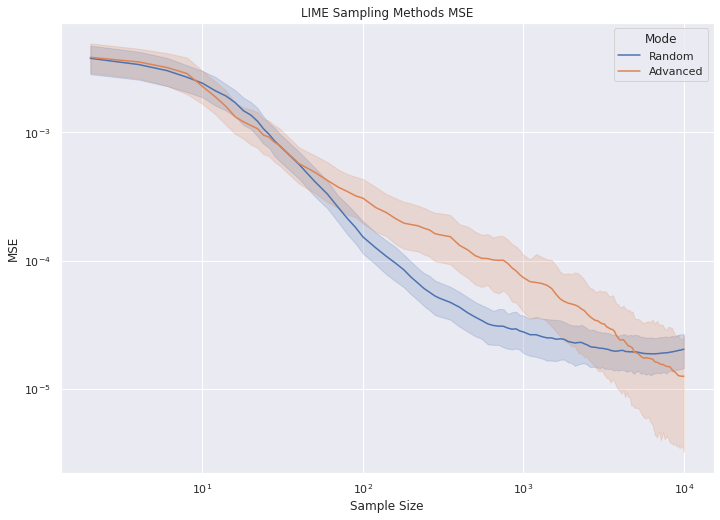

In [10]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.lineplot(data=e, x="sample_size", y='MSE', hue='Mode')
g.set(xscale="log") 
g.set(yscale="log")
g.set(xlabel="Sample Size")
g.set(ylabel="MSE")
g.set(title="LIME Sampling Methods MSE")
plt.savefig("./plots/mse.pdf")